# Refactored ODL Notebook

Refactored to use avg_time=1 data. Made 06/10/2023

06/24/2023 focus as of now is comparing ship plot stuff, looking at source level for different locations and different MMSIs

**Shared MMSI Between AB and CC**

`352358000, 356190000, 538005544`

## Imports

In [1]:
# data
from obspy import read as obsread
import ooipy
from ooipy.tools import ooiplotlib as ooiplt
import pandas as pd
import numpy as np
#import functions as fn
# plotting
#import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.colors import Normalize
from matplotlib.backends.backend_agg import FigureCanvasAgg
# IO
from io import BytesIO
import io
import json
from scipy.io import wavfile

# general
from datetime import datetime
import re

from scipy.signal import welch

from geopy.distance import geodesic
import plotly.express as px
import datetime

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Functions

In [2]:
CC_node_LF = 'Central_Caldera'
EC_node_LF = 'Eastern_Caldera'
ecdist = (45.9399, -129.9742)
ccdist = (45.9549, -130.0089)
abdist = (45.8168, -129.7543)
def animate_map(ais, starttime, endtime):
    subais = ais[(ais['TIMESTAMP UTC'] > starttime) & (ais['TIMESTAMP UTC'] < endtime)]
    time = subais['TIMESTAMP UTC']
    for i in time:
        #subais.loc[len(subais.index)] = [0,0,'cc hydrophone'+str(i),'cc hydrophone',0,0,0, -130.0089,45.9549,0,0, i, 0,0]
        subais.loc[len(subais.index)] = [0,0, 'cc hydrophone '+str(i), 'cc hydrophone', 0,0,0,i,0, 0,0,45.9549, -130.0089, 0, 0,0,0,0,0,0]
        #subais.loc[len(subais.index)] = [0,0,'ec hydrophone'+str(i),'ec hydrophone',0,0,10, -129.9742,45.9399,0,0, i, 0,0]
        subais.loc[len(subais.index)] = [0,0, 'ec hydrophone '+str(i), 'ec hydrophone', 0,0,0,i,0, 0,0,45.9399, -129.9742, 0, 0,0,0,0,0,0]
        subais.loc[len(subais.index)] = [0,0, 'ab hydrophone '+str(i), 'ab hydrophone', 0,0,0,i,0, 0,0,45.8168, -129.7543, 0, 0,0,0,0,0,0]
    subais = subais.reset_index()
    for i in range(len(subais)):
        subais.loc[i,'TIMESTAMP UTC'] = subais.iloc[i]['TIMESTAMP UTC']- datetime.timedelta(minutes=subais.iloc[i]['TIMESTAMP UTC'].minute % 10)
    subais['TIMESTAMP UTC'] = subais['TIMESTAMP UTC'].dt.to_period('T')
    fig = px.scatter_mapbox(subais,
              lat="LAT" ,
              lon="LON",
              hover_name="VESSEL TYPE",
              hover_data= ['SPEED (KNOTSx10)','ccdist'],
              color="SHIPNAME",
              animation_frame=subais['TIMESTAMP UTC'].astype(dtype=str),
              mapbox_style='carto-positron',                 
              zoom=5)
    fig.show()

def get_PSD_dict(meta_data_CSV_path, location, close_distance=False):
    """
    Generate a dictionary that holds PSD data
    Ex. psd_dict[ship_type][freq_values] # not actual key names
    This data gets passed into the spdf generation and plotting functions
    
    Parameters
    ----------
    meta_data_CSV_path : str
        A file path that points to the .csv that contains the metadata. 
        Mainly used to group based on ship type (ud_group). Also matches instance_id
        to corresponding ship type.

    location : str
        String containing location of the hydrophone (i.e. Axial_Base).
        Used for file pathing

    Returns
    -------
    dict: a nested dictionary for ship type and their respective PSD data
    """

    df = pd.read_csv(meta_data_CSV_path, sep=',')

    if close_distance:
        depth_dict = {
            "Axial_Base": 3,
            "Eastern_Caldera": 1.5,
            "Central_Caldera": 1.5,
            "Oregon_Slope": 3,
            "Southern_Hydrate": 0.8
        }
        # subset to close instances
        df = df.loc[df["mean_distance(in kms)"] <= depth_dict[location]]
        df = df.reset_index(drop=True)

    # EC is the only one with missing ship type and only 4 of them, just ignore those
    # .dropna() followed by .groupby() cleans and groups
    grouped_df = df.dropna(subset=['ud_group']).groupby('ud_group')

    # https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
    PSDs = {}
    for group_name, df_group in grouped_df:
        PSD_obj_list = []
        PSD_freq = []
        PSD_val = []
        dictPSD = {'objects': PSD_obj_list, 'frequencies': PSD_freq, 'values': PSD_val}

        # for-loop to compile list of PSD data objects pulled from column
        for row_index, row in df_group.iterrows():
            inst_id = df['instance_id'].iloc[row_index]
            # get pickle files (DL locally? Call some API?)
            # local storage method
            data_path = 'data/' + location + '/'
            pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.pkl'
            # try-except deals with missing pickles
            try:
                with open(pklfilepath, 'rb') as f:
                    dict1 = json.load(f)
                #print("----------PKL FOUND----------")
                # create PSD object and fill out PSD object fields
                psd = ooipy.Psd(dict1['f'], dict1['psd'])
                dictPSD['objects'].append(psd)
                dictPSD['frequencies'].append(psd.freq)
                dictPSD['values'].append(psd.values)
            except FileNotFoundError:
                #print("Could not find pkl")
                pass
        PSDs.update({group_name: dictPSD})
    return PSDs

# function pulled from https://github.com/Ocean-Data-Lab/Website-backend     
def get_spdf(spec, fs_hz=200, fmax=None, spl_bins=np.linspace(0, 120, 481),
             percentiles=[1, 5, 10, 50, 90, 95, 99]):
    if fmax is None:
        fmax = 100 #spec.frequency[-1]

    n_freq_bin = int(len(spec['frequencies'][0]) * fmax/(fs_hz/2)) + 1

    spdf_dct = {'freq': np.array(np.linspace(0, fmax, n_freq_bin)),
                'spl': spl_bins[:-1],
                'pdf': np.empty((n_freq_bin, 480))
                #'number_psd': len(spec.time) this isn't used
                }

    for p in percentiles:
        spdf_dct[str(p)] = np.empty(n_freq_bin)

    for idx, freq_bin in enumerate(np.asarray(spec['values']).T[:n_freq_bin - 1]):
        hist, _ = np.histogram(freq_bin, bins=spl_bins, density=True)
        spdf_dct['pdf'][idx] = hist
        spdf_dct['50'][idx] = np.median(freq_bin)
        for p in percentiles:
            spdf_dct[str(p)][idx] = np.nanquantile(freq_bin, p/100)

    return spdf_dct

def plot_spdf(spdf, vmin=0.003, vmax=0.2, vdelta=0.0025, save=False, filename=None, log=True, title='Spectral PDF', shipType=None, location=None):
    cbarticks = np.arange(vmin, vmax+vdelta, vdelta)
    fig, ax = plt.subplots(figsize=(9, 5))
    im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),
                     cbarticks, norm=colors.Normalize(vmin=vmin, vmax=vmax),
                     cmap='jet', extend='max', alpha=0.50, linewidth=0)

    # plot some percentiles:
    plt.plot(spdf['freq'], spdf['1'], color='black')
    plt.plot(spdf['freq'], spdf['5'], color='black')
    plt.plot(spdf['freq'], spdf['10'], color='black')
    plt.plot(spdf['freq'], spdf['50'], color='black')
    plt.plot(spdf['freq'], spdf['90'], color='black')
    plt.plot(spdf['freq'], spdf['95'], color='black')
    plt.plot(spdf['freq'], spdf['99'], color='black')

    plt.ylabel(r'spectral level (dB rel $1 \mathrm{\frac{μ Pa^2}{Hz}}$)')
    plt.xlabel('frequency (Hz)')
    plt.ylim([36, 100])
    plt.xlim([0, 90])
    if log:
        plt.xscale('log')

    plt.colorbar(im, ax=ax, ticks=[vmin, vmin + (vmax-vmin)/4, vmin + (vmax-vmin)/2,
                 vmin + 3*(vmax-vmin)/4,  vmax],  pad=0.03, label='probability', format='%.3f')
    plt.tick_params(axis='y')
    plt.grid(True)
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    line = Line2D(
        [0], [0], label='percentiles: 1, 5, 10, 50, 90, 95, 99', color='k')
    handles.extend([line])
    plt.legend(handles=handles, loc='upper right')
    plt.tight_layout()
    plt.xlim((200/512, 100))
    filepath = 'data/'+location+'/'
    #plt.savefig(filepath+shipType+'.jpg', format='jpg')
    plt.savefig(filepath+title+'.jpg', format='jpg')
    plt.close() # suppress plotting

def get_PSD_dict_given_filt_df(df, location, close_distance=False):
    df = df.reset_index(drop=True)
    """df = pd.read_csv(meta_data_CSV_path, sep=',')

    if close_distance:
        depth_dict = {
            "Axial_Base": 3,
            "Eastern_Caldera": 1.5,
            "Central_Caldera": 1.5,
            "Oregon_Slope": 3,
            "Southern_Hydrate": 0.8
        }
        # subset to close instances
        df = df.loc[df["mean_distance(in kms)"] <= depth_dict[location]]
        df = df.reset_index(drop=True)"""

    # https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
    PSD_obj_list = []
    PSD_freq = []
    PSD_val = []
    dictPSD = {'objects': PSD_obj_list, 'frequencies': PSD_freq, 'values': PSD_val}

    # for-loop to compile list of PSD data objects pulled from column
    for row_index, row in df.iterrows():
        inst_id = df['instance_id'].iloc[row_index]
        # get pickle files (DL locally? Call some API?)
        # local storage method
        data_path = 'data/' + location + '/'
        pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.json'
        #if (location == 'Eastern_Caldera'):
        #    pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.pkl'
        # try-except deals with missing pickles
        try:
            print(pklfilepath)
            with open(pklfilepath, 'rb') as f:
                dict1 = json.load(f)
            #print("----------PKL FOUND----------")
            # create PSD object and fill out PSD object fields
            psd = ooipy.Psd(dict1['f'], dict1['psd'])
            dictPSD['objects'].append(psd)
            dictPSD['frequencies'].append(psd.freq)
            dictPSD['values'].append(psd.values)
        except FileNotFoundError:
            #print("Could not find pkl")
            #pass
            try:
                pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.pkl'
                with open(pklfilepath, 'rb') as f:
                    dict1 = json.load(f)
                #print("----------PKL FOUND----------")
                # create PSD object and fill out PSD object fields
                psd = ooipy.Psd(dict1['f'], dict1['psd'])
                dictPSD['objects'].append(psd)
                dictPSD['frequencies'].append(psd.freq)
                dictPSD['values'].append(psd.values)
            except FileNotFoundError:
                pass
    #PSDs.update({group_name: dictPSD})
    return dictPSD

def Rx_level_from_df(df,location):

    """
    Requires dataframe for specific MMSI and maybe filtered to be sufficiently close to hydrophone.

    Return lists that contain range values (closest to farthest) within a set range (df param should already be filtered),
    and a list that contains the receive level, which is calculated from the FFT of the time series data.
    Due to needing the time series data, may be time-consuming to run.
    This data can be used to get source levels by adding/making up from Tx loss using a separate function.

    Parameters
    ----------
    df : Pandas dataframe
        A dataframe that is filtered to only contain one MMSI. Should probably also be close to hydrophone.

    Returns
    -------
    R : a list of range values in kilometers. When using it for Tx loss, need to make it an array and *1000 to get meters.

    Rx_level : a list of receive levels


    """

    df = df.sort_values(by=['distance(in km)'])
    df = df.reset_index(drop=True)

    Rx_level = []
    R = []
    file404 = 0
    for row_index, row in df.iterrows():
        try:
            inst = df['instance_id'].loc[row_index]
            #print(inst)
            st = obsread('data/'+location+'/Mseed/'+inst+'.mseed')
            data = st[-1].data
            #print(st[-1])
            
            Fs = 200
            N = len(data)
            freqs = np.linspace(-(Fs/2), Fs/2, N) # divide by 2 for nyquist, center on zero for fftshift. N points to match with N points in recording
            ft_data = np.fft.fft(data)
            idx_5hz = 63000 # index corresponding to frequency of 5 on the frequency domain centered on zero
            idx_90hz = 114000

            # Follows equation to get sound exposure
            # Guerra_Thode_et al_2011
            SE = np.sum(np.fft.fftshift(np.abs(ft_data)**2)[idx_5hz:idx_90hz] / (N * Fs))
            SEL = 10 * np.log10(SE) # dB conversion
            #print(f'SEL = {SEL}')
            Rx_level.append(SEL)
            R.append(df['distance(in km)'].loc[row_index])
            #print(df['mean_distance(in kms)'].loc[row_index])
        except FileNotFoundError:
            file404 +=  1
            pass

    print(f'Files not found: {file404}')
    return R, Rx_level

def Rx_level_from_df_SPEED(df,location):

    df = df.sort_values(by=['SPEED (KNOTSx10)'])
    df = df.reset_index(drop=True)

    Rx_level = []
    S = []
    file404 = 0
    for row_index, row in df.iterrows():
        try:
            inst = df['instance_id'].loc[row_index]
            #print(inst)
            st = obsread('data/'+location+'/Mseed/'+inst+'.mseed')
            data = st[-1].data
            #print(st[-1])
            
            Fs = 200
            N = len(data)
            freqs = np.linspace(-(Fs/2), Fs/2, N) # divide by 2 for nyquist, center on zero for fftshift. N points to match with N points in recording
            ft_data = np.fft.fft(data)
            idx_5hz = 63000 # index corresponding to frequency of 5 on the frequency domain centered on zero
            idx_90hz = 114000

            # Follows equation to get sound exposure
            # Guerra_Thode_et al_2011
            SE = np.sum(np.fft.fftshift(np.abs(ft_data)**2)[idx_5hz:idx_90hz] / (N * Fs))
            SEL = 10 * np.log10(SE) # dB conversion
            #print(f'SEL = {SEL}')
            Rx_level.append(SEL)
            S.append(df['SPEED (KNOTSx10)'].loc[row_index])
            #print(df['mean_distance(in kms)'].loc[row_index])
        except FileNotFoundError:
            file404 +=  1
            pass

    print(f'Files not found: {file404}')
    return S, Rx_level

Tx_loss1 = lambda x: 20*np.log10(x*1000)
#Tx_loss2 = lambda x: 20*np.log10(3*1000)+10*np.log10((x*1000)/(3*1000))

def Tx_loss2(x, location):
    depth_dict = {
            "AB": 3,
            "EC": 1.5,
            "CC": 1.5,
            "OS": 3,
            "SH": 0.8
        }
    return 20*np.log10(depth_dict[location]*1000)+10*np.log10((x*1000)/(depth_dict[location]*1000))


## Work

### Eastern Caldera

#### SPDF

In [13]:
EC_df = pd.read_csv('data/Eastern_Caldera/EC_isolated_ais_5_20.csv', sep=',')

# Cargo
key = 'Cargo'
MMSI_1 = 372305000
MMSI_2 = 356190000
MMSI_3 = 538005544
MMSI_4 = 352358000
MMSI = MMSI_3
df = EC_df[(EC_df['ud_group']==key)]
df = df[df['MMSI']==MMSI]
#df = df[:-1]
#df.groupby('MMSI').count() # this lets us see MMSI occurances
psd = get_PSD_dict_given_filt_df(df, 'Eastern_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF ('+str(MMSI)+')', shipType=key, location='Eastern_Caldera')
#end_time = (pd.to_datetime(df['TIMESTAMP UTC'].iloc[5], format='%Y-%m-%d %H:%M:%S'))
#start_time = (pd.to_datetime(df['TIMESTAMP UTC'].iloc[0], format='%Y-%m-%d %H:%M:%S'))
#start_time = (pd.to_datetime('2016-08-28 08:36:44', format='%Y-%m-%d %H:%M:%S'))
#EC_hdata_LF = ooipy.get_acoustic_data_LF(start_time, end_time, EC_node_LF, verbose=True, zero_mean=True)
#EC_spec_LF = EC_hdata_LF.compute_spectrogram(avg_time=1, overlap=0)

#ooipy.plot(EC_spec_LF, fmin=0, fmax=100, xlabel_rot=30)

data/Eastern_Caldera/PSD_pickles/EC_20161127172108_20161127173108.json
data/Eastern_Caldera/PSD_pickles/EC_20161127172108_20161127173108.json
data/Eastern_Caldera/PSD_pickles/EC_20161127173108_20161127174108.json


C:\Users\UserALai\AppData\Local\Temp\ipykernel_1880\3544942638.py:130: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


In [11]:
node = 'Eastern_Caldera'
psd_pickle_filename = 'data/Eastern_Caldera/PSD_pickles/EC_'
mseed_filename = 'data/Eastern_Caldera/Mseed/EC_'
for index, row in df.iterrows():
    #start_time = row['start']
    inst_id = row['instance_id']
    start_time = datetime.datetime.strptime(inst_id[3:17], "%Y%m%d%H%M%S")
    str_starttime = start_time.strftime("%Y%m%d%H%M%S")
    end_time = datetime.datetime.strptime(inst_id[18:], "%Y%m%d%H%M%S")
    str_endtime = end_time.strftime("%Y%m%d%H%M%S")
    print(f'start: {start_time}, end: {end_time}')
    try: 
        data_trace = ooipy.get_acoustic_data_LF(start_time, end_time, node, verbose=True, zero_mean=True)
        psd = data_trace.compute_psd_welch(L = 256, overlap=0.3)
        psd.save(filename=psd_pickle_filename+str_starttime+'_'+str_endtime+'.json')
        data_trace.write(mseed_filename+str_starttime+'_'+str_endtime+'.mseed', format='MSEED')
    except: 
        pass

start: 2016-11-27 17:21:08, end: 2016-11-27 17:31:08
start: 2016-11-27 17:21:08, end: 2016-11-27 17:31:08
start: 2016-11-27 17:31:08, end: 2016-11-27 17:41:08


In [14]:
df

,Unnamed: 0,MMSI,SHIPNAME,VESSEL TYPE,SPEED (KNOTSx10),COURSE,HEADING,TIMESTAMP UTC,LENGTH,Year,ship_Loc,LAT,LON,distance(in km),eastern_caldera_Loc,instance_id,ud_group
16926,16926,538005544,GLORY,Bulk Carrier,87,73,80,2016-11-27 17:21:08,225.0,2016,"(45.93698, -130.0219)",45.93698,-130.0219,3.71,"(45.9399, -129.9742)",EC_20161127172108_20161127173108,Cargo
16927,16927,538005544,GLORY,Bulk Carrier,90,76,80,2016-11-27 17:27:37,225.0,2016,"(45.94065, -129.9995)",45.94065,-129.9995,1.96,"(45.9399, -129.9742)",EC_20161127172108_20161127173108,Cargo
16928,16928,538005544,GLORY,Bulk Carrier,90,76,80,2016-11-27 17:35:07,225.0,2016,"(45.94502, -129.9735)",45.94502,-129.9735,0.57,"(45.9399, -129.9742)",EC_20161127173108_20161127174108,Cargo


In [19]:
psd = get_PSD_dict_given_filt_df(df.iloc[0:1], 'Eastern_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF inst 0 '+str(MMSI), shipType=key, location='Eastern_Caldera')


data/Eastern_Caldera/PSD_pickles/EC_20161127172108_20161127173108.json


C:\Users\UserALai\AppData\Local\Temp\ipykernel_2408\3544942638.py:130: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


#### Extended Spectrogram

c:\Users\UserALai\miniconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 4096 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\UserALai\miniconda3\lib\site-packages\ooipy\tools\ooiplotlib.py:218: UserWarning: The following kwargs were not used by contour: 'fmin', 'fmax', 'xlabel_rot', 'plot', 'save', 'filename', 'title', 'xlabel', 'xlabel_format', 'ylabel', 'vdelta', 'vdelta_cbar', 'figsize', 'res_reduction_time', 'res_reduction_freq', 'dpi', 'fontsize', 'extend_type', 'logy'
  ax.contourf(


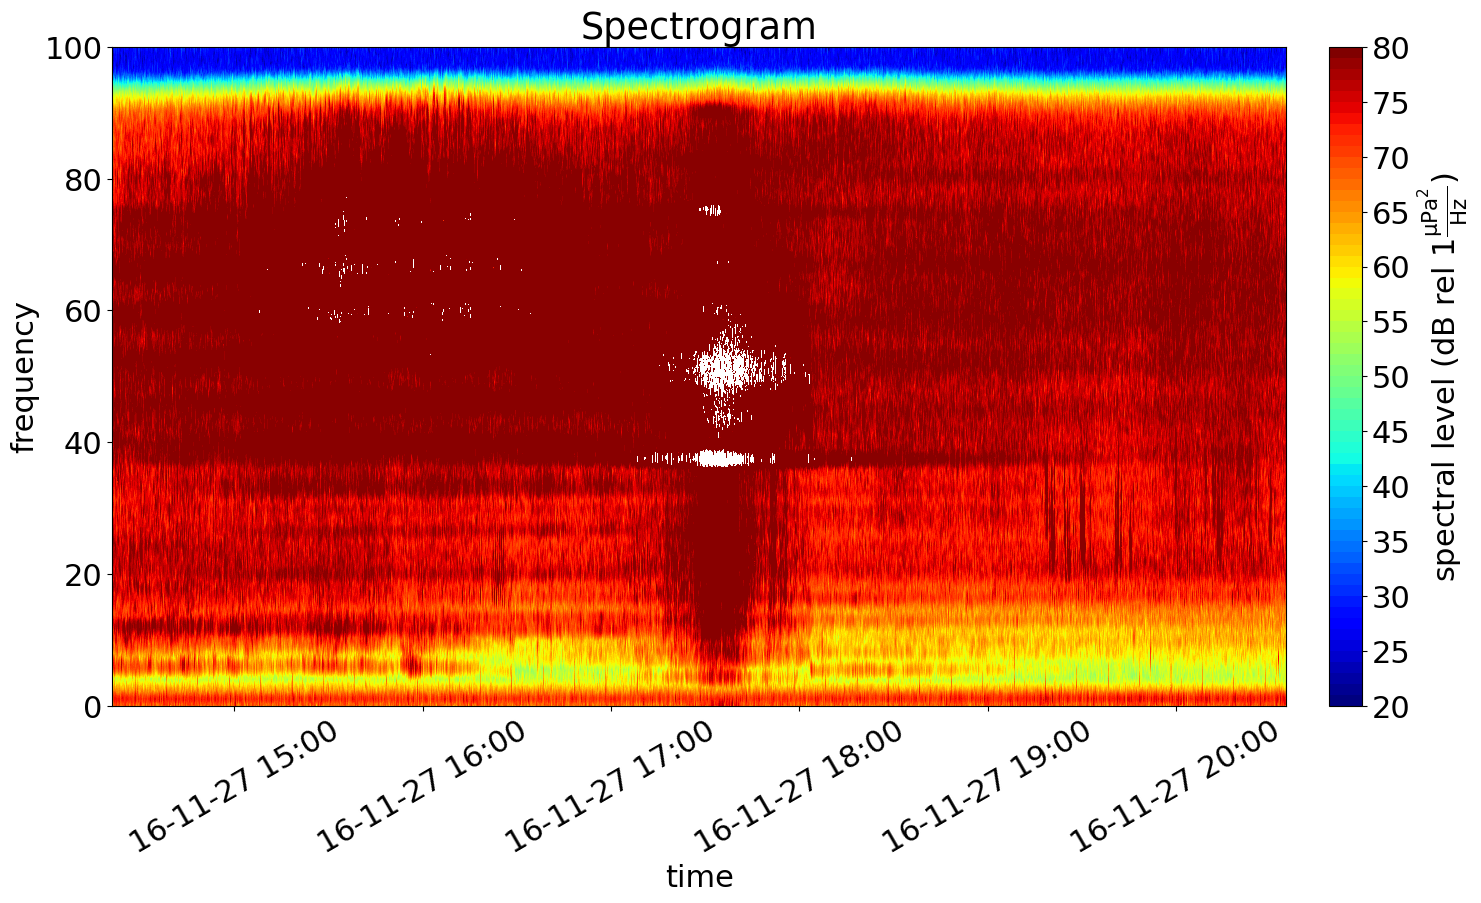

In [20]:
start_time = (pd.to_datetime('2016-11-27 14:21:08', format='%Y-%m-%d %H:%M:%S'))
end_time = (pd.to_datetime('2016-11-27 20:35:07', format='%Y-%m-%d %H:%M:%S'))

#end_time = (pd.to_datetime('2017-07-27 13:07:23', format='%Y-%m-%d %H:%M:%S'))
hdata_CC = ooipy.get_acoustic_data_LF(start_time, end_time, 'Eastern_Caldera', verbose=True, zero_mean=True)
CC_spec_LF = hdata_CC.compute_spectrogram(avg_time=1, overlap=0)

ooipy.plot(CC_spec_LF, fmin=0, fmax=100, xlabel_rot=30)

In [53]:
start_time = (pd.to_datetime('2017-08-16 08:49:50', format='%Y-%m-%d %H:%M:%S'))
end_time = (pd.to_datetime('2017-08-16 15:49:51', format='%Y-%m-%d %H:%M:%S'))

#end_time = (pd.to_datetime('2017-07-27 13:07:23', format='%Y-%m-%d %H:%M:%S'))
hdata_EC = ooipy.get_acoustic_data_LF(start_time, end_time, 'Eastern_Caldera', verbose=True, zero_mean=True)
EC_spec_LF = hdata_EC.compute_spectrogram(avg_time=1, overlap=0)

ooipy.plot(EC_spec_LF, fmin=0, fmax=100, xlabel_rot=30)

   error loading data from OOI server.
      likely that time window doesn't have data


AttributeError: 'NoneType' object has no attribute 'compute_spectrogram'

#### Source Level & SEL vs. Range

Files not found: 0


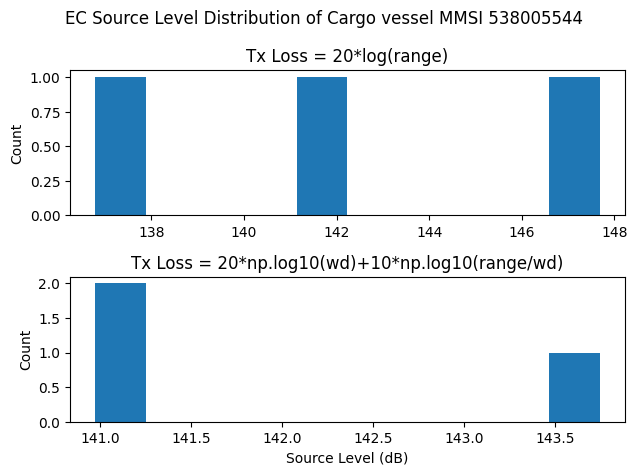

In [12]:
R, Rx_level = Rx_level_from_df(df, 'Eastern_Caldera')

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('EC Source Level Distribution of '+key+' vessel MMSI ' + str(MMSI))
loss = np.abs(Tx_loss1(np.asarray(R)))
ax1.hist(np.ma.masked_invalid(Rx_level+loss)) # hide inf (0 divide error) since it messes w/ plotting
ax1.set_ylabel('Count')
ax1.title.set_text('Tx Loss = 20*log(range)')
loss = np.abs(Tx_loss2(np.asarray(R), 'EC'))
ax2.hist(np.ma.masked_invalid(Rx_level+loss))
ax2.set_xlabel('Source Level (dB)')
ax2.set_ylabel('Count')
ax2.title.set_text('Tx Loss = 20*np.log10(wd)+10*np.log10(range/wd)')
fig.tight_layout() 

Text(0.5, 0, 'Range (km)')

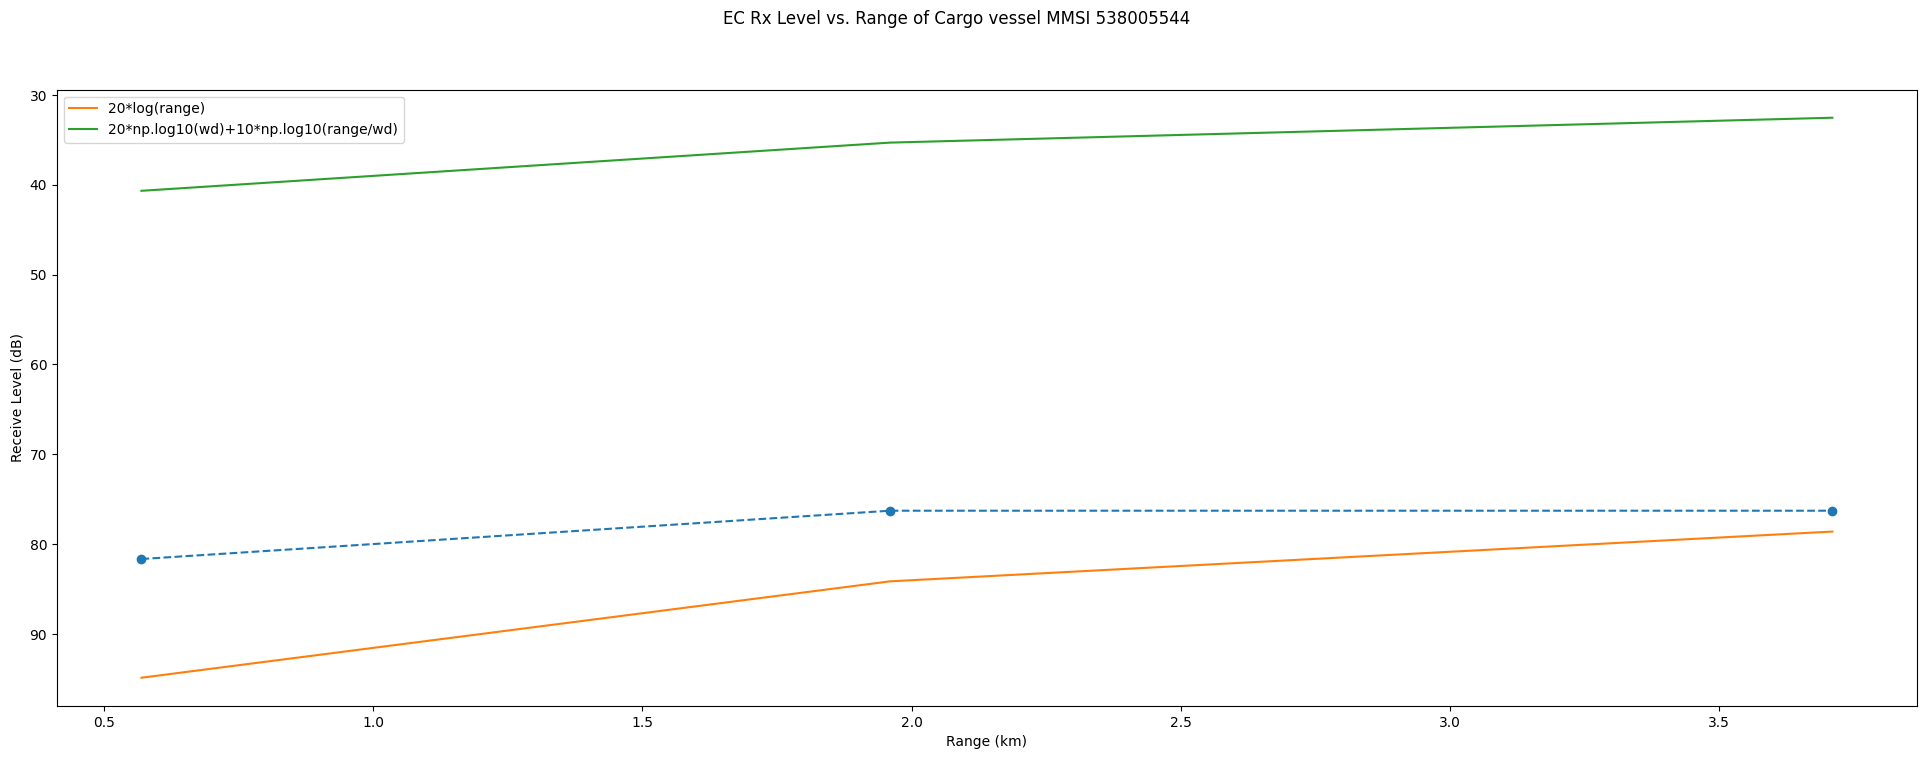

In [13]:
fig, ax = plt.subplots(figsize=(24,8))

fig.suptitle('EC Rx Level vs. Range of '+key+' vessel MMSI ' + str(MMSI))

ax.plot(R, Rx_level, 'o--')
ax.plot(R, -1*Tx_loss1(np.asarray(R))+150, label='20*log(range)')
ax.plot(R, -1*Tx_loss2(np.asarray(R), 'CC')+100, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Range (km)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Files not found: 0


Text(0.5, 0, 'Speed (Knots x 10)')

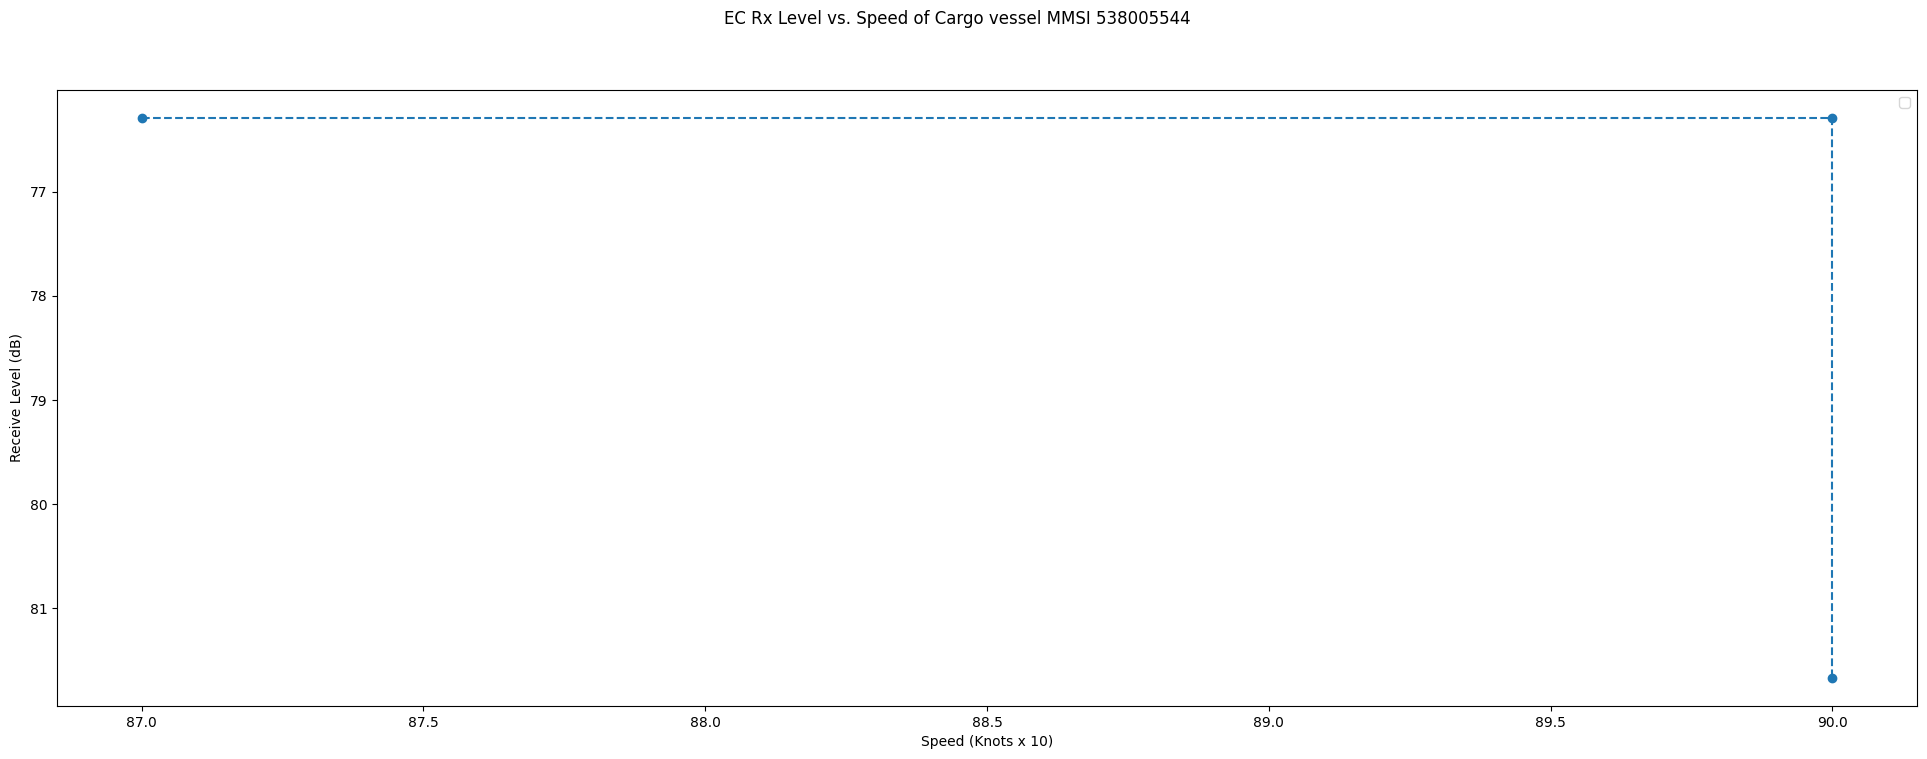

In [14]:
S, Rx_level = Rx_level_from_df_SPEED(df, 'Eastern_Caldera')
fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('EC Rx Level vs. Speed of '+key+' vessel MMSI ' + str(MMSI))

ax.plot(S, Rx_level, 'o--')
#ax.plot(S, -1*Tx_loss1(np.asarray(S))+150, label='20*log(range)')
#ax.plot(S, -1*Tx_loss2(np.asarray(S), 'CC')+100, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Speed (Knots x 10)')

#### AIS Mapping

In [15]:
ais = df

abdist = (45.8168, -129.7543)
ecdist = (45.9399, -129.9742)
ccdist = (45.9549, -130.0089)
ais['ecdist'] = [geodesic((a, b), ecdist).miles for a, b in ais[['LAT', 'LON']].values]
ais['ccdist'] = [geodesic((a, b), ccdist).miles for a, b in ais[['LAT', 'LON']].values]
ais['abdist'] = [geodesic((a, b), abdist).miles for a, b in ais[['LAT', 'LON']].values]

ais['TIMESTAMP UTC'] = pd.to_datetime(ais['TIMESTAMP UTC']).dt.strftime('%Y-%m-%d %H:%M:%S')
ais['TIMESTAMP UTC'] = pd.to_datetime(ais['TIMESTAMP UTC'])

#animate_map('2016-08-28 09:03:45', '2016-08-28 13:02:04')
animate_map(ais, '2017-07-27 07:03:10', '2017-08-16 12:59:51')
#2016-08-28 13:02:04



### Central Caldera

#### SPDF

In [11]:
CC_df = pd.read_csv('data/Central_Caldera/CC_isolated_ais_5_20.csv', sep=',')

# Cargo
key = 'Cargo'
MMSI_1 = 372305000
MMSI_2 = 356190000
MMSI_3 = 538005544
MMSI_4 = 352358000
MMSI = MMSI_3
df = CC_df[(CC_df['ud_group']==key)]
df = df[df['MMSI']==MMSI]
# df.groupby('MMSI').count() # this lets us see MMSI occurances
psd = get_PSD_dict_given_filt_df(df, 'Central_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF ('+str(MMSI)+')', shipType=key, location='Central_Caldera')
#end_time = (pd.to_datetime(df['TIMESTAMP UTC'].iloc[5], format='%Y-%m-%d %H:%M:%S'))
#start_time = (pd.to_datetime('2016-08-28 06:03:45', format='%Y-%m-%d %H:%M:%S'))

data/Central_Caldera/PSD_pickles/CC_20161127172108_20161127173108.json
data/Central_Caldera/PSD_pickles/CC_20161127172108_20161127173108.json


C:\Users\UserALai\AppData\Local\Temp\ipykernel_1880\3544942638.py:130: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


In [12]:
df

,Unnamed: 0,MMSI,SHIPNAME,VESSEL TYPE,SPEED (KNOTSx10),COURSE,HEADING,TIMESTAMP UTC,LENGTH,Year,ship_Loc,LAT,LON,distance(in km),central_caldera_Loc,instance_id,ud_group
16570,16570,538005544,GLORY,Bulk Carrier,87,73,80,2016-11-27 17:21:08,225.0,2016,"(45.93698, -130.0219)",45.93698,-130.0219,2.23,"(45.9549, -130.0089)",CC_20161127172108_20161127173108,Cargo
16571,16571,538005544,GLORY,Bulk Carrier,90,76,80,2016-11-27 17:27:37,225.0,2016,"(45.94065, -129.9995)",45.94065,-129.9995,1.74,"(45.9549, -130.0089)",CC_20161127172108_20161127173108,Cargo


In [47]:

psd = get_PSD_dict_given_filt_df(df[df['TIMESTAMP UTC'] == '2016-08-20 09:07:51'], 'Central_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF inst 0 ' + str(MMSI), shipType=key, location='Central_Caldera')


data/Central_Caldera/PSD_pickles/CC_20160820090751_20160820091751.json
data/Central_Caldera/PSD_pickles/CC_20150819201406_20150819202406.json
data/Central_Caldera/PSD_pickles/CC_20150826134825_20150826135825.json


C:\Users\UserALai\AppData\Local\Temp\ipykernel_8168\126937450.py:130: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


In [54]:
psd = get_PSD_dict_given_filt_df(df.iloc[0:1], 'Central_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF inst 0 538005544', shipType=key, location='Central_Caldera')

psd = get_PSD_dict_given_filt_df(df.iloc[1:], 'Central_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF inst 1 538005544', shipType=key, location='Central_Caldera')

data/Central_Caldera/PSD_pickles/CC_20161127172108_20161127173108.json


C:\Users\UserALai\AppData\Local\Temp\ipykernel_18384\126937450.py:130: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


data/Central_Caldera/PSD_pickles/CC_20161127172108_20161127173108.json


#### Extended Spectrogram

c:\Users\UserALai\miniconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 4096 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\UserALai\miniconda3\lib\site-packages\ooipy\tools\ooiplotlib.py:218: UserWarning: The following kwargs were not used by contour: 'fmin', 'fmax', 'xlabel_rot', 'plot', 'save', 'filename', 'title', 'xlabel', 'xlabel_format', 'ylabel', 'vdelta', 'vdelta_cbar', 'figsize', 'res_reduction_time', 'res_reduction_freq', 'dpi', 'fontsize', 'extend_type', 'logy'
  ax.contourf(


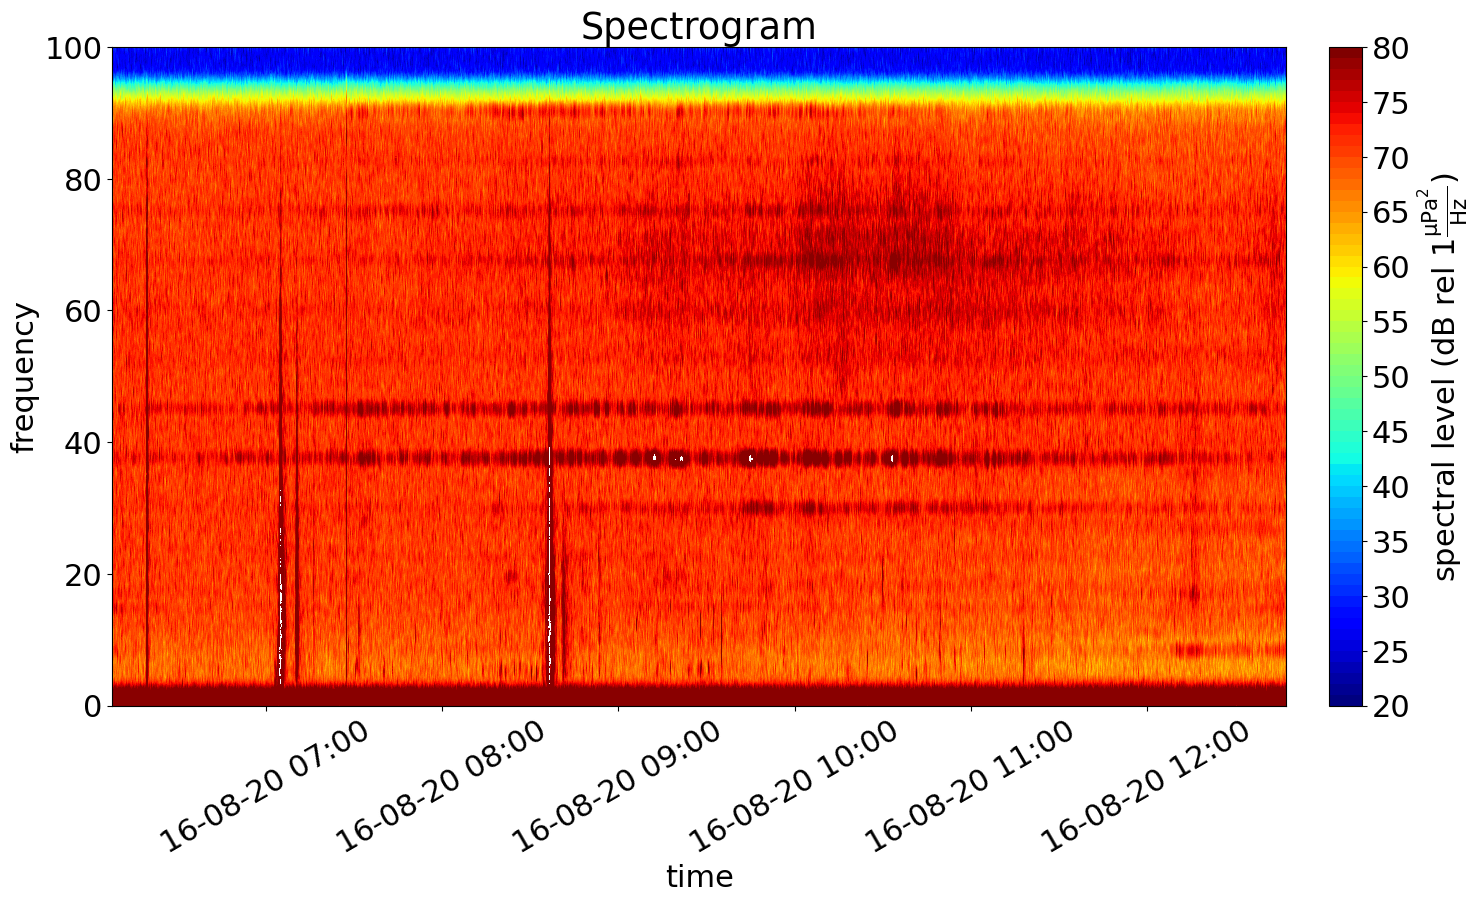

In [23]:
start_time = (pd.to_datetime('2016-08-20 06:07:51', format='%Y-%m-%d %H:%M:%S'))
end_time = (pd.to_datetime('2016-08-20 12:47:19', format='%Y-%m-%d %H:%M:%S'))

#end_time = (pd.to_datetime('2017-07-27 13:07:23', format='%Y-%m-%d %H:%M:%S'))
hdata_CC = ooipy.get_acoustic_data_LF(start_time, end_time, 'Central_Caldera', verbose=True, zero_mean=True)
CC_spec_LF = hdata_CC.compute_spectrogram(avg_time=1, overlap=0)

ooipy.plot(CC_spec_LF, fmin=0, fmax=100, xlabel_rot=30)

#### Source Level & SEL vs. Range

Files not found: 0


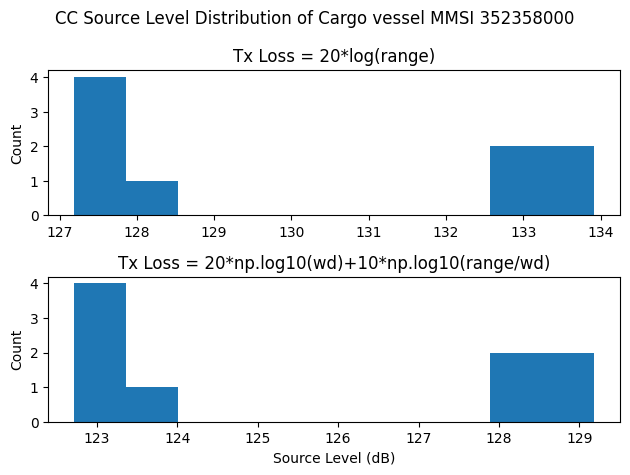

In [12]:
R, Rx_level = Rx_level_from_df(df, 'Central_Caldera')

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('CC Source Level Distribution of '+key+' vessel MMSI ' + str(MMSI))
loss = np.abs(Tx_loss1(np.asarray(R)))
ax1.hist(np.ma.masked_invalid(Rx_level+loss)) # hide inf (0 divide error) since it messes w/ plotting
ax1.set_ylabel('Count')
ax1.title.set_text('Tx Loss = 20*log(range)')
loss = np.abs(Tx_loss2(np.asarray(R), 'CC'))
ax2.hist(np.ma.masked_invalid(Rx_level+loss))
ax2.set_xlabel('Source Level (dB)')
ax2.set_ylabel('Count')
ax2.title.set_text('Tx Loss = 20*np.log10(wd)+10*np.log10(range/wd)')
fig.tight_layout() 

Text(0.5, 0, 'Range (km)')

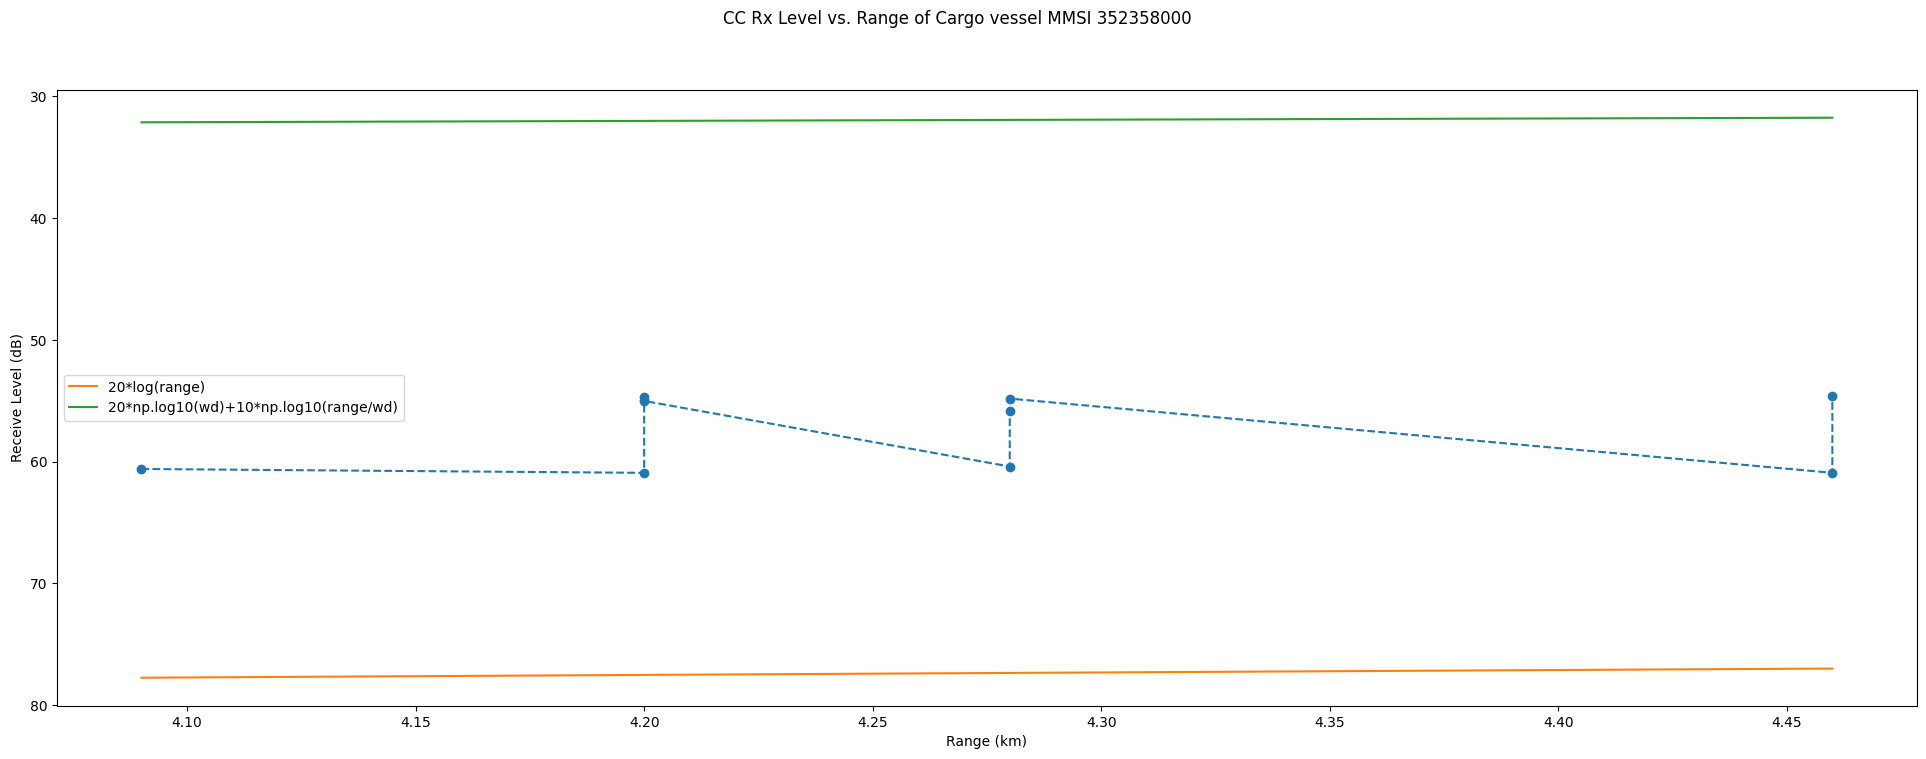

In [13]:
fig, ax = plt.subplots(figsize=(24,8))

fig.suptitle('CC Rx Level vs. Range of '+key+' vessel MMSI ' + str(MMSI))

ax.plot(R, Rx_level, 'o--')
ax.plot(R, -1*Tx_loss1(np.asarray(R))+150, label='20*log(range)')
ax.plot(R, -1*Tx_loss2(np.asarray(R), 'CC')+100, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Range (km)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Files not found: 0


Text(0.5, 0, 'Speed (Knots x 10)')

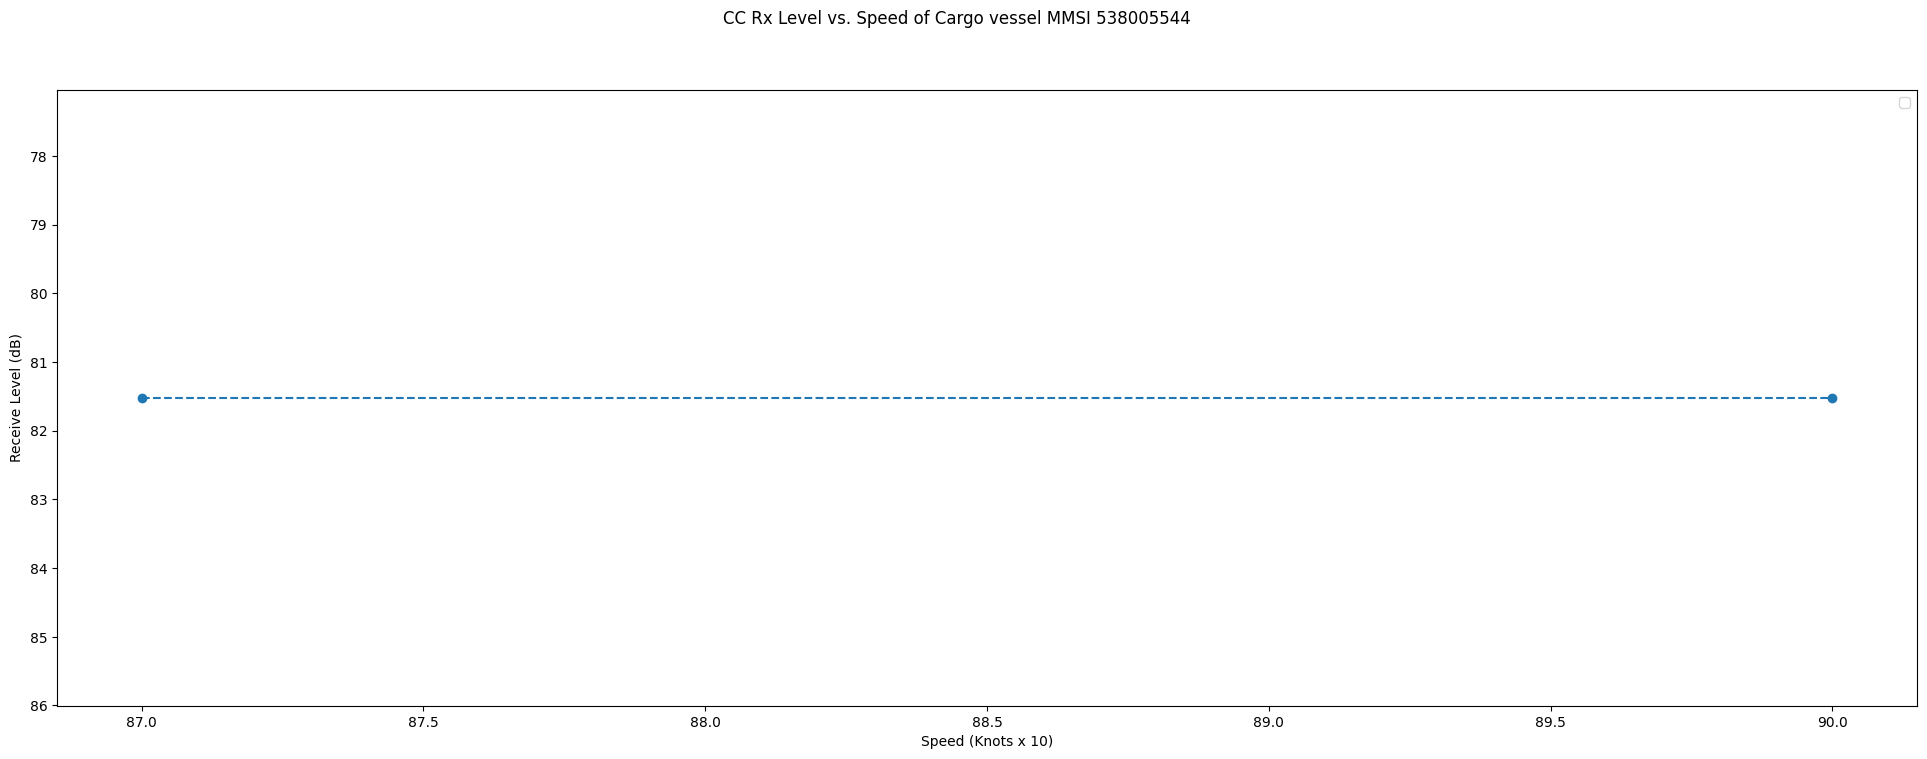

In [22]:
S, Rx_level = Rx_level_from_df_SPEED(df, 'Central_Caldera')
fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('CC Rx Level vs. Speed of '+key+' vessel MMSI ' + str(MMSI))

ax.plot(S, Rx_level, 'o--')
#ax.plot(S, -1*Tx_loss1(np.asarray(S))+150, label='20*log(range)')
#ax.plot(S, -1*Tx_loss2(np.asarray(S), 'CC')+100, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Speed (Knots x 10)')

#### AIS Mapping

In [15]:
ais = df

abdist = (45.8168, -129.7543)
ecdist = (45.9399, -129.9742)
ccdist = (45.9549, -130.0089)
ais['ecdist'] = [geodesic((a, b), ecdist).miles for a, b in ais[['LAT', 'LON']].values]
ais['ccdist'] = [geodesic((a, b), ccdist).miles for a, b in ais[['LAT', 'LON']].values]
ais['abdist'] = [geodesic((a, b), abdist).miles for a, b in ais[['LAT', 'LON']].values]

ais['TIMESTAMP UTC'] = pd.to_datetime(ais['TIMESTAMP UTC']).dt.strftime('%Y-%m-%d %H:%M:%S')
ais['TIMESTAMP UTC'] = pd.to_datetime(ais['TIMESTAMP UTC'])

animate_map(ais, '2016-08-28 09:03:45', '2016-08-28 13:02:04')

c:\Users\UserALai\miniconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [2]:
import datetime
start_time = datetime.datetime(2017,7,1,0,0,0)
end_time = datetime.datetime(2017,7,1,0,1,0)
node1 = 'LJ01D'
node2 = 'Eastern_Caldera'

print('Downloading Low Frequency Data:')
hdata_lowfreq = ooipy.get_acoustic_data_LF(start_time, end_time, node2, verbose=True, zero_mean=True)
print(hdata_lowfreq.stats)

         network: OO
         station: AXEC2
        location: AXEC2
         channel: HDH
       starttime: 2017-07-01T00:00:00.000000Z
         endtime: 2017-07-01T00:01:00.000000Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 12001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 12, 'encoding': 'FLOAT32', 'byteorder': '>', 'record_length': 4096, 'filesize': 49152})


### Axial Base


#### Counting instances

In [34]:
AB_df.groupby('MMSI').count()

,Unnamed: 0,SHIPNAME,VESSEL TYPE,SPEED (KNOTSx10),COURSE,HEADING,TIMESTAMP UTC,LENGTH,Year,ship_Loc,LAT,LON,distance(in km),axial_Loc,instance_id,ud_group
MMSI,,,,,,,,,,,,,,,,
210059000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
212250000,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
212482000,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
220518000,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
249666000,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
255805893,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
303031000,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
303681000,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
311000243,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11


#### SPDF

In [9]:
AB_df = pd.read_csv('data/Axial_Base/AB_isolated_ais_5_20.csv', sep=',')

# Cargo
key = 'Cargo'
MMSI_1 = 372305000
MMSI_2 = 356190000
MMSI_3 = 538005544
MMSI_4 = 352358000
MMSI = MMSI_3
df = AB_df[(AB_df['ud_group']==key)]
df = df[df['MMSI']==MMSI]
# df.groupby('MMSI').count() # this lets us see MMSI occurances
psd = get_PSD_dict_given_filt_df(df, 'Axial_Base')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF ('+str(MMSI)+')', shipType=key, location='Axial_Base')

data/Axial_Base/PSD_pickles/AB_20161126212006_20161126213006.json
data/Axial_Base/PSD_pickles/AB_20161126213006_20161126214006.json
data/Axial_Base/PSD_pickles/AB_20161126214006_20161126215006.json


C:\Users\UserALai\AppData\Local\Temp\ipykernel_1880\3544942638.py:130: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


In [10]:
df

,Unnamed: 0,MMSI,SHIPNAME,VESSEL TYPE,SPEED (KNOTSx10),COURSE,HEADING,TIMESTAMP UTC,LENGTH,Year,ship_Loc,LAT,LON,distance(in km),axial_Loc,instance_id,ud_group
6411,6411,538005544,GLORY,Bulk Carrier,70,119,115,2016-11-26 21:20:06,225.0,2016,"(45.83273, -129.8096)",45.83273,-129.8096,4.67,"(45.8168, -129.754)",AB_20161126212006_20161126213006,Cargo
6412,6412,538005544,GLORY,Bulk Carrier,70,118,117,2016-11-26 21:37:19,225.0,2016,"(45.81673, -129.7667)",45.81673,-129.7667,0.99,"(45.8168, -129.754)",AB_20161126213006_20161126214006,Cargo
6413,6413,538005544,GLORY,Bulk Carrier,71,117,115,2016-11-26 21:49:48,225.0,2016,"(45.80545, -129.7361)",45.80545,-129.7361,1.88,"(45.8168, -129.754)",AB_20161126214006_20161126215006,Cargo


In [66]:
psd1 = get_PSD_dict_given_filt_df(df.iloc[14:15], 'Axial_Base')
spdf1 = get_spdf(psd1)
plot_spdf(spdf1, log=False, title=key + ' Spectral PDF inst 14 ' + str(MMSI), shipType=key, location='Axial_Base')

data/Axial_Base/PSD_pickles/AB_20150728120811_20150728121811.json


C:\Users\UserALai\AppData\Local\Temp\ipykernel_8168\126937450.py:130: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


#### Testing Getting more Data using functions.py

In [4]:
import functions as fn

ais = pd.read_csv('C:/Users/UserALai/Downloads/2017B - Updated.csv')
ais[ais['MMSI'] == MMSI]

,MMSI,SHIPNAME,VESSEL TYPE,STATUS,SPEED (KNOTSx10),LAT,LON,COURSE,HEADING,TIMESTAMP UTC,LENGTH
5953,356190000,PANTERA ROSA,Bulk Carrier,0,121,44.94703,-129.1385,329,329,2017-07-26 21:54:17,225.0
5973,356190000,PANTERA ROSA,Bulk Carrier,0,113,45.70712,-129.7581,330,329,2017-07-27 02:18:17,225.0
5977,356190000,PANTERA ROSA,Bulk Carrier,0,114,45.81064,-129.8424,329,329,2017-07-27 02:55:34,225.0
5983,356190000,PANTERA ROSA,Bulk Carrier,0,84,45.99289,-129.9945,331,328,2017-07-27 04:02:56,225.0
5990,356190000,PANTERA ROSA,Bulk Carrier,2,7,45.99192,-130.0131,160,221,2017-07-27 05:37:24,225.0
...,...,...,...,...,...,...,...,...,...,...,...
37636,356190000,PANTERA ROSA,Bulk Carrier,0,114,46.60880,-130.8140,283,284,2017-10-30 08:05:06,225.0
37644,356190000,PANTERA ROSA,Bulk Carrier,0,113,46.63559,-130.9723,282,284,2017-10-30 08:40:29,225.0
37652,356190000,PANTERA ROSA,Bulk Carrier,0,114,46.64405,-131.0218,282,284,2017-10-30 08:51:38,225.0
37671,356190000,PANTERA ROSA,Bulk Carrier,0,116,46.66926,-131.1685,284,287,2017-10-30 09:24:07,225.0


#### Extended Spectrogram
Take an hour or two before first time stamp and plot up to maybe 10 minutes after it to see the start of the recording


c:\Users\UserALai\miniconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 4096 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\UserALai\miniconda3\lib\site-packages\ooipy\tools\ooiplotlib.py:218: UserWarning: The following kwargs were not used by contour: 'fmin', 'fmax', 'xlabel_rot', 'plot', 'save', 'filename', 'title', 'xlabel', 'xlabel_format', 'ylabel', 'vdelta', 'vdelta_cbar', 'figsize', 'res_reduction_time', 'res_reduction_freq', 'dpi', 'fontsize', 'extend_type', 'logy'
  ax.contourf(


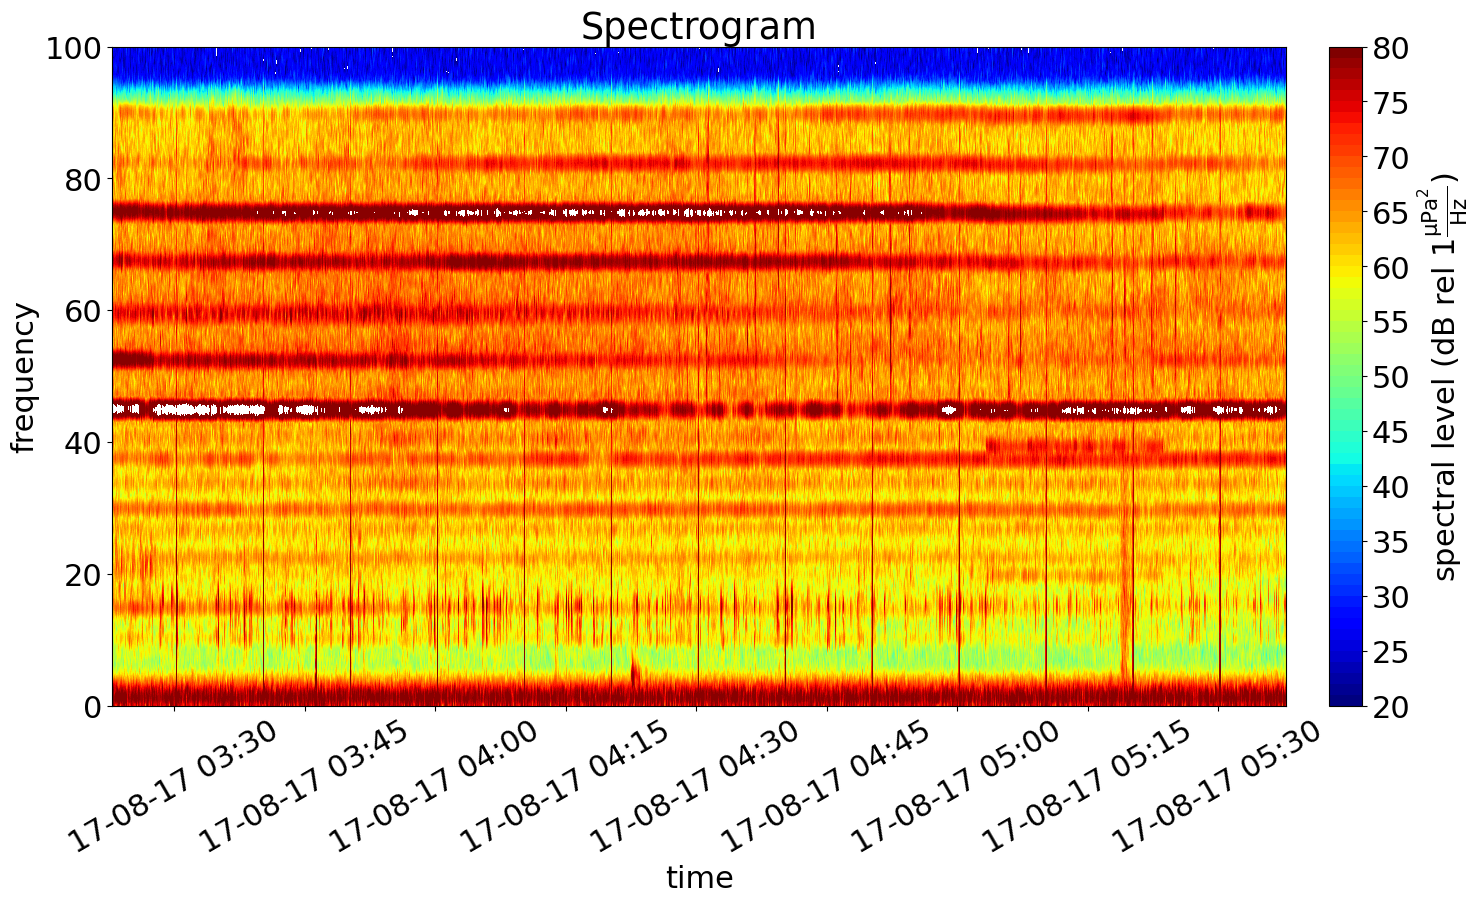

In [5]:
start_time = (pd.to_datetime('2017-08-17 03:22:52', format='%Y-%m-%d %H:%M:%S'))
end_time = (pd.to_datetime('2017-08-17 05:37:51', format='%Y-%m-%d %H:%M:%S'))
hdata_AB = ooipy.get_acoustic_data_LF(start_time, end_time, 'Axial_Base', verbose=True, zero_mean=True)
AB_spec_LF = hdata_AB.compute_spectrogram(avg_time=1, overlap=0,average_type="mean")

ooipy.plot(AB_spec_LF, fmin=0, fmax=100, xlabel_rot=30)

In [13]:
MMSI

356190000

#### Source Level & SEL vs. Range


Files not found: 0


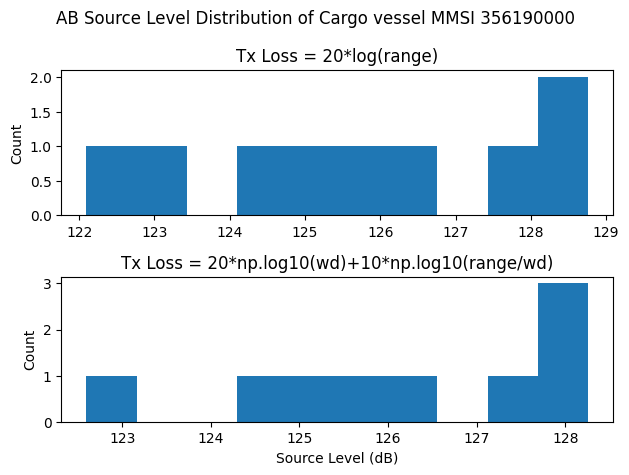

In [9]:
R, Rx_level = Rx_level_from_df(df, 'Axial_Base')

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('AB Source Level Distribution of '+key+' vessel MMSI ' + str(MMSI))
loss = np.abs(Tx_loss1(np.asarray(R)))
ax1.hist(np.ma.masked_invalid(Rx_level+loss)) # hide inf (0 divide error) since it messes w/ plotting
ax1.set_ylabel('Count')
ax1.title.set_text('Tx Loss = 20*log(range)')
loss = np.abs(Tx_loss2(np.asarray(R), 'AB'))
ax2.hist(np.ma.masked_invalid(Rx_level+loss))
ax2.set_xlabel('Source Level (dB)')
ax2.set_ylabel('Count')
ax2.title.set_text('Tx Loss = 20*np.log10(wd)+10*np.log10(range/wd)')
fig.tight_layout() 

Text(0.5, 0, 'Range (km)')

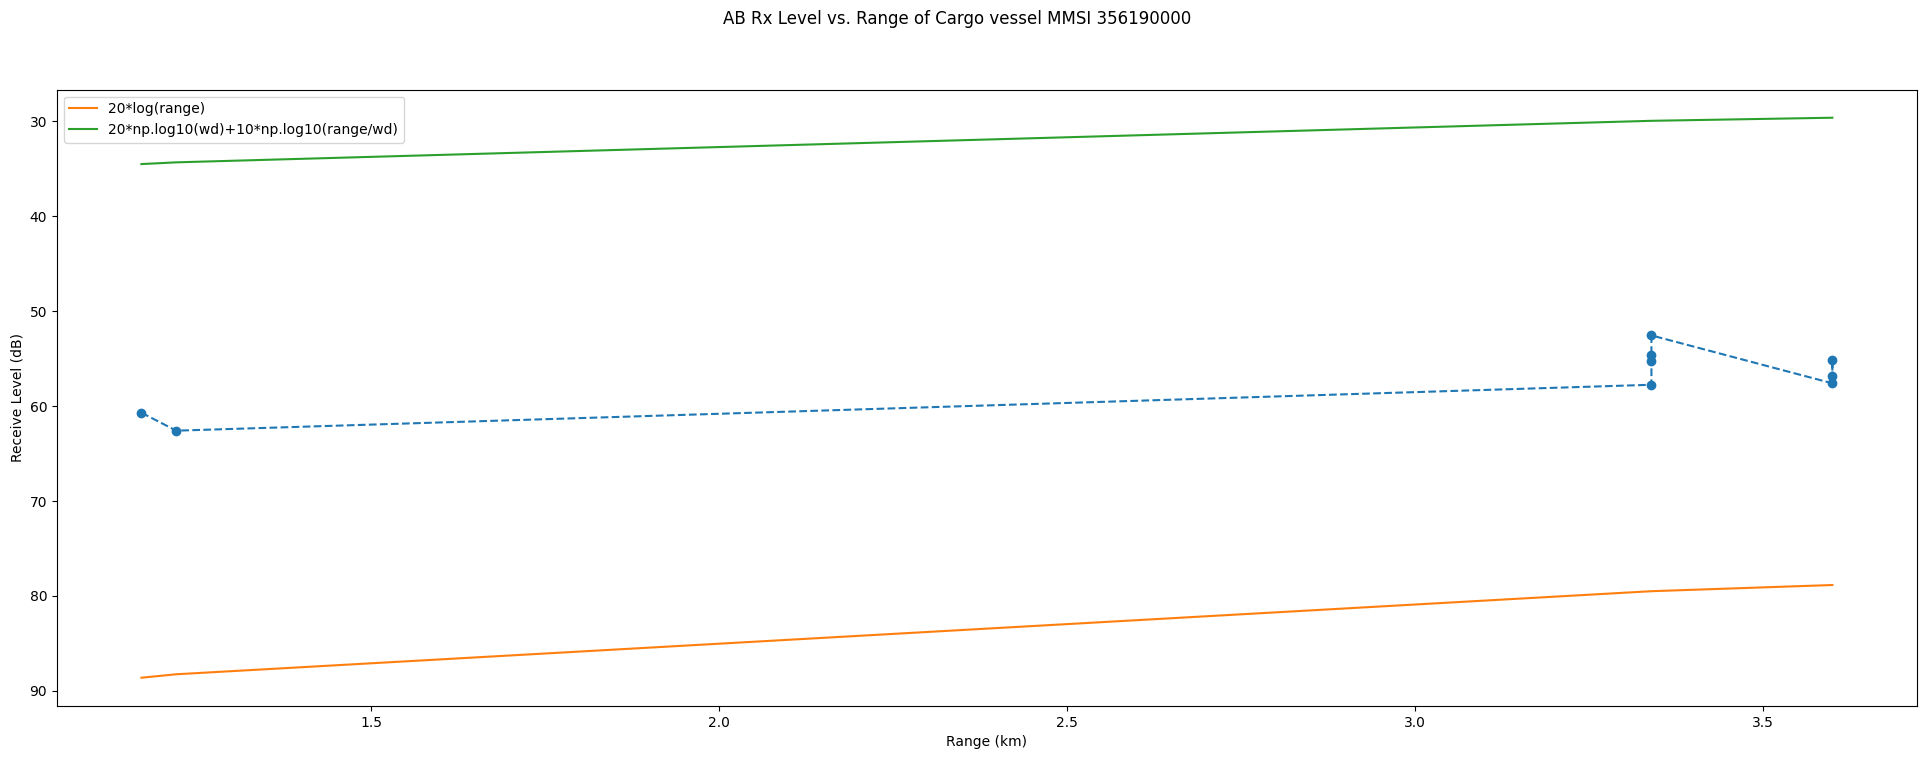

In [10]:
fig, ax = plt.subplots(figsize=(24,8))

fig.suptitle('AB Rx Level vs. Range of '+key+' vessel MMSI ' + str(MMSI))

ax.plot(R, Rx_level, 'o--')
ax.plot(R, -1*Tx_loss1(np.asarray(R))+150, label='20*log(range)')
ax.plot(R, -1*Tx_loss2(np.asarray(R), 'AB')+100, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Range (km)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Files not found: 0


Text(0.5, 0, 'Speed (Knots x 10)')

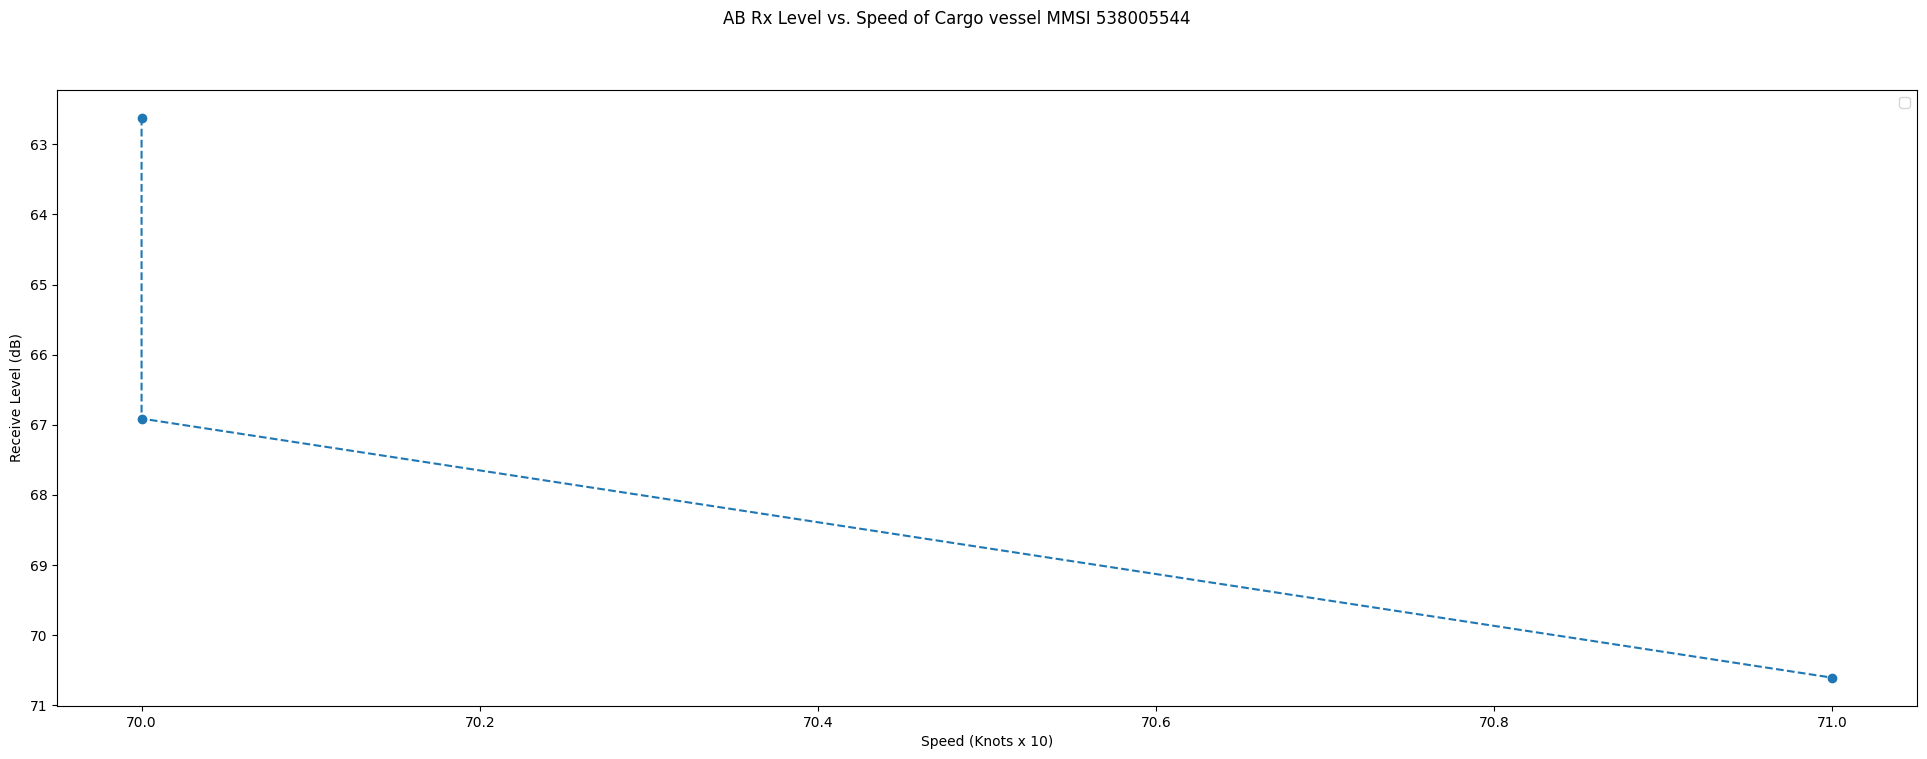

In [20]:
S, Rx_level = Rx_level_from_df_SPEED(df, 'Axial_Base')
fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('AB Rx Level vs. Speed of '+key+' vessel MMSI ' + str(MMSI))

ax.plot(S, Rx_level, 'o--')
#ax.plot(S, -1*Tx_loss1(np.asarray(S))+150, label='20*log(range)')
#ax.plot(S, -1*Tx_loss2(np.asarray(S), 'CC')+100, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Speed (Knots x 10)')

#### AIS Mapping

In [19]:
ais = df

abdist = (45.8168, -129.7543)
ecdist = (45.9399, -129.9742)
ccdist = (45.9549, -130.0089)
ais['ecdist'] = [geodesic((a, b), ecdist).miles for a, b in ais[['LAT', 'LON']].values]
ais['ccdist'] = [geodesic((a, b), ccdist).miles for a, b in ais[['LAT', 'LON']].values]
ais['abdist'] = [geodesic((a, b), abdist).miles for a, b in ais[['LAT', 'LON']].values]

ais['TIMESTAMP UTC'] = pd.to_datetime(ais['TIMESTAMP UTC']).dt.strftime('%Y-%m-%d %H:%M:%S')
ais['TIMESTAMP UTC'] = pd.to_datetime(ais['TIMESTAMP UTC'])

animate_map(ais, '2017-08-17 03:12:52', '2017-08-17 05:47:51')

In [17]:
ais

,Unnamed: 0,MMSI,SHIPNAME,VESSEL TYPE,SPEED (KNOTSx10),COURSE,HEADING,TIMESTAMP UTC,LENGTH,Year,ship_Loc,LAT,LON,distance(in km),axial_Loc,instance_id,ud_group,ecdist,ccdist,abdist
577,577,356190000,PANTERA ROSA,Bulk Carrier,6,141,225,2017-08-17 03:22:52,225.0,2017,"(45.81182, -129.7672)",45.81182,-129.7672,1.17,"(45.8168, -129.754)",AB_20170817032252_20170817033252,Cargo,13.340391,15.282831,0.711630
579,579,356190000,PANTERA ROSA,Bulk Carrier,9,159,226,2017-08-17 03:43:51,225.0,2017,"(45.80788, -129.7632)",45.80788,-129.7632,1.22,"(45.8168, -129.754)",AB_20170817034252_20170817035252,Cargo,13.665743,15.606493,0.751183
589,589,356190000,PANTERA ROSA,Bulk Carrier,12,156,222,2017-08-17 05:28:51,225.0,2017,"(45.78728, -129.7459)",45.78728,-129.7459,3.34,"(45.8168, -129.754)",AB_20170817052252_20170817053252,Cargo,15.246422,17.175991,2.078750
590,590,356190000,PANTERA ROSA,Bulk Carrier,10,157,223,2017-08-17 05:37:51,225.0,2017,"(45.78505, -129.7446)",45.78505,-129.7446,3.60,"(45.8168, -129.754)",AB_20170817053252_20170817054252,Cargo,15.398528,17.326462,2.242280
775,775,356190000,PANTERA ROSA,Bulk Carrier,12,156,222,2017-08-17 05:28:51,225.0,2017,"(45.78728, -129.7459)",45.78728,-129.7459,3.34,"(45.8168, -129.754)",AB_20150713101749_20150713102749,Cargo,15.246422,17.175991,2.078750
776,776,356190000,PANTERA ROSA,Bulk Carrier,10,157,223,2017-08-17 05:37:51,225.0,2017,"(45.78505, -129.7446)",45.78505,-129.7446,3.60,"(45.8168, -129.754)",AB_20150713102749_20150713103749,Cargo,15.398528,17.326462,2.242280
962,962,356190000,PANTERA ROSA,Bulk Carrier,12,156,222,2017-08-17 05:28:51,225.0,2017,"(45.78728, -129.7459)",45.78728,-129.7459,3.34,"(45.8168, -129.754)",AB_20150726155521_20150726160521,Cargo,15.246422,17.175991,2.078750
963,963,356190000,PANTERA ROSA,Bulk Carrier,10,157,223,2017-08-17 05:37:51,225.0,2017,"(45.78505, -129.7446)",45.78505,-129.7446,3.60,"(45.8168, -129.754)",AB_20150726160521_20150726161521,Cargo,15.398528,17.326462,2.242280
1151,1151,356190000,PANTERA ROSA,Bulk Carrier,12,156,222,2017-08-17 05:28:51,225.0,2017,"(45.78728, -129.7459)",45.78728,-129.7459,3.34,"(45.8168, -129.754)",AB_20150728200341_20150728201341,Cargo,15.246422,17.175991,2.078750


In [11]:
subais = ais[(ais['TIMESTAMP UTC'] > pd.to_datetime('2017-08-17 03:22:52')) & (ais['TIMESTAMP UTC'] < pd.to_datetime('2017-08-17 05:28:51'))]
time = subais['TIMESTAMP UTC']
for i in time:
    #subais.loc[len(subais.index)] = [0,0,'cc hydrophone'+str(i),'cc hydrophone',0,0,0, -130.0089,45.9549,0,0, i, 0,0]
    subais.loc[len(subais.index)] = [0,0, 'cc hydrophone '+str(i), 'cc hydrophone', 0,0,0,i,0, 0,0,45.9549, -130.0089, 0, 0,0,0,0,0,0]
    #subais.loc[len(subais.index)] = [0,0,'ec hydrophone'+str(i),'ec hydrophone',0,0,10, -129.9742,45.9399,0,0, i, 0,0]
    subais.loc[len(subais.index)] = [0,0, 'ec hydrophone '+str(i), 'ec hydrophone', 0,0,0,i,0, 0,0,45.9399, -129.9742, 0, 0,0,0,0,0,0]
    subais.loc[len(subais.index)] = [0,0, 'ab hydrophone '+str(i), 'ab hydrophone', 0,0,0,i,0, 0,0,45.8168, -129.7543, 0, 0,0,0,0,0,0]
subais = subais.reset_index()
for i in range(len(subais)):
    subais.loc[i,'TIMESTAMP UTC'] = subais.iloc[i]['TIMESTAMP UTC']- datetime.timedelta(minutes=subais.iloc[i]['TIMESTAMP UTC'].minute % 10)
subais['TIMESTAMP UTC'] = subais['TIMESTAMP UTC'].dt.to_period('T')
fig = px.scatter_mapbox(subais,
            lat="LAT" ,
            lon="LON",
            hover_name="VESSEL TYPE",
            hover_data= ['SPEED (KNOTSx10)','ccdist'],
            color="SHIPNAME",
            animation_frame=subais['TIMESTAMP UTC'].astype(dtype=str),
            mapbox_style='carto-positron',                 
            zoom=5)
fig.show()

c:\Users\UserALai\miniconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
subais

,index,Unnamed: 0,MMSI,SHIPNAME,VESSEL TYPE,SPEED (KNOTSx10),COURSE,HEADING,TIMESTAMP UTC,LENGTH,...,ship_Loc,LAT,LON,distance(in km),axial_Loc,instance_id,ud_group,ecdist,ccdist,abdist
0,579,579,356190000,PANTERA ROSA,Bulk Carrier,9,159,226,2017-08-17 03:40,225.0,...,"(45.80788, -129.7632)",45.80788,-129.7632,1.22,"(45.8168, -129.754)",AB_20170817034252_20170817035252,Cargo,13.665743,15.606493,0.751183
1,1,0,0,cc hydrophone 2017-08-17 03:43:51,cc hydrophone,0,0,0,2017-08-17 03:40,0.0,...,0,45.95490,-130.0089,0.00,0,0,0,0.000000,0.000000,0.000000
2,2,0,0,ec hydrophone 2017-08-17 03:43:51,ec hydrophone,0,0,0,2017-08-17 03:40,0.0,...,0,45.93990,-129.9742,0.00,0,0,0,0.000000,0.000000,0.000000
3,3,0,0,ab hydrophone 2017-08-17 03:43:51,ab hydrophone,0,0,0,2017-08-17 03:40,0.0,...,0,45.81680,-129.7543,0.00,0,0,0,0.000000,0.000000,0.000000


In [13]:
subais.columns

Index(['index', 'Unnamed: 0', 'MMSI', 'SHIPNAME', 'VESSEL TYPE',
       'SPEED (KNOTSx10)', 'COURSE', 'HEADING', 'TIMESTAMP UTC', 'LENGTH',
       'Year', 'ship_Loc', 'LAT', 'LON', 'distance(in km)', 'axial_Loc',
       'instance_id', 'ud_group', 'ecdist', 'ccdist', 'abdist'],
      dtype='object')

In [25]:
blah = pd.merge(AB_df[AB_df['ud_group'] == 'Cargo'], CC_df[CC_df['ud_group'] == 'Cargo'], on='MMSI')
glah = blah.groupby('MMSI')
clah = glah.count()


In [29]:
glah.groups.keys()

dict_keys([352358000, 356190000, 538005544])

In [33]:
AB_df[AB_df['MMSI'] == 352358000]

,Unnamed: 0,MMSI,SHIPNAME,VESSEL TYPE,SPEED (KNOTSx10),COURSE,HEADING,TIMESTAMP UTC,LENGTH,Year,ship_Loc,LAT,LON,distance(in km),axial_Loc,instance_id,ud_group
547,547,352358000,ANNA G.,Bulk Carrier,23,127,80,2016-08-20 14:17:31,229.0,2016,"(45.83979, -129.7672)",45.83979,-129.7672,2.75,"(45.8168, -129.754)",AB_20160820141731_20160820142731,Cargo
548,548,352358000,ANNA G.,Bulk Carrier,22,128,81,2016-08-20 14:24:43,229.0,2016,"(45.83675, -129.7619)",45.83675,-129.7619,2.30,"(45.8168, -129.754)",AB_20160820141731_20160820142731,Cargo
549,549,352358000,ANNA G.,Bulk Carrier,22,123,78,2016-08-20 14:33:07,229.0,2016,"(45.83339, -129.7558)",45.83339,-129.7558,1.85,"(45.8168, -129.754)",AB_20160820142731_20160820143731,Cargo
550,550,352358000,ANNA G.,Bulk Carrier,22,126,80,2016-08-20 14:43:53,229.0,2016,"(45.82935, -129.7479)",45.82935,-129.7479,1.47,"(45.8168, -129.754)",AB_20160820143731_20160820144731,Cargo
553,553,352358000,ANNA G.,Bulk Carrier,22,132,79,2016-08-20 15:08:58,229.0,2016,"(45.81873, -129.7299)",45.81873,-129.7299,1.89,"(45.8168, -129.754)",AB_20160820150731_20160820151731,Cargo
555,555,352358000,ANNA G.,Bulk Carrier,24,127,81,2016-08-20 15:36:41,229.0,2016,"(45.80688, -129.7095)",45.80688,-129.7095,3.63,"(45.8168, -129.754)",AB_20160820152731_20160820153731,Cargo
733,733,352358000,ANNA G.,Bulk Carrier,23,127,80,2016-08-20 14:17:31,229.0,2016,"(45.83979, -129.7672)",45.83979,-129.7672,2.75,"(45.8168, -129.754)",AB_20150713031749_20150713032749,Cargo
734,734,352358000,ANNA G.,Bulk Carrier,22,128,81,2016-08-20 14:24:43,229.0,2016,"(45.83675, -129.7619)",45.83675,-129.7619,2.30,"(45.8168, -129.754)",AB_20150713032749_20150713033749,Cargo
735,735,352358000,ANNA G.,Bulk Carrier,22,123,78,2016-08-20 14:33:07,229.0,2016,"(45.83339, -129.7558)",45.83339,-129.7558,1.85,"(45.8168, -129.754)",AB_20150713033749_20150713034749,Cargo
741,741,352358000,ANNA G.,Bulk Carrier,24,127,81,2016-08-20 15:36:41,229.0,2016,"(45.80688, -129.7095)",45.80688,-129.7095,3.63,"(45.8168, -129.754)",AB_20150713043749_20150713044749,Cargo
